 # 1. Introduction: Business Problem 

In this project, I would like to find out a suitable location for a pet company to expand its business in New York City. The
demand of pet food, pet toy and other pet supplies will be the concern of the pet company. Therefore, todiscover the most 
suitable location, we need to figure out the places of the greatest concentrationo of dogs. 

# 2. Data

New York has a total of 5 boroughs and 306 neighborhoods. It is necessarilty to have a dataset which contains all 5 boroughs and the 306 neighborhoods that exist in each borough, also the the latitude and logitude coordinates of each neighborhood.
We are able to find the dataset from following links:
https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

https://data.beta.nyc/en/dataset/pediacities-nyc-neighborhoods/resource/7caac650-d082-4aea-9f9b-3681d568e8a5?inner_span=True

https://data.beta.nyc/dataset/pediacities-nyc-neighborhoods

In addition, we need a dataset about the license of dogs in NYC. We are able to find the dataset from NYC OpenData page: https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp

The original datasets called "df_merged" include data as follow:
RowNumber, AnimalName, AnimalGender, AnimalBirthMonth, BreedName, Borough, ZipCode, LicenseIssuedDate, LicenseExpiredDate, Extract Year, borough, post_office, neighborhood, population, density.

Another dataset called "df_segmentation2" is the one we need to getting familiar with the customers and will include data as follow: 
Dogs_Name, Dogs_Gender, Dogs_BirthYear ,Breed_Name, Borough, Neighborhood.

We need to find out the place which is the greatest concentration of dogs, there be the place for pet company to expand.

In [3]:
# Import the libraries first!

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import json
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

! pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans

import folium 

print('Libraries imported.')

Libraries imported.


In [9]:
df_0=pd.read_csv('NYC_Dog_Licensing_Dataset.csv') 
print(df_1.head())
df_0.shape

  RowNumber AnimalName AnimalGender  AnimalBirthMonth  \
0         1      PAIGE            F              2014   
1         2       YOGI            M              2010   
2         3        ALI            M              2014   
3         4      QUEEN            F              2013   
4         5       LOLA            F              2009   

                              BreedName  Borough  ZipCode LicenseIssuedDate  \
0  American Pit Bull Mix / Pit Bull Mix      NaN    10035        09/12/2014   
1                                 Boxer      NaN    10465        09/12/2014   
2                               Basenji      NaN    10013        09/12/2014   
3                      Akita Crossbreed      NaN    10013        09/12/2014   
4                               Maltese      NaN    10028        09/12/2014   

  LicenseExpiredDate  Extract Year  
0         09/12/2017          2016  
1         10/02/2017          2016  
2         09/12/2019          2016  
3         09/12/2017          2016

(345727, 10)

In [11]:
df_nyczipcod=pd.read_csv('nyc_zip_borough_neighborhoods_pop.csv') 
print(df_nyzipcod.head())

df_nyczipcod.shape

     zip    borough   post_office         neighborhood  population  density
0  10001  Manhattan  New York, NY  Chelsea and Clinton       21102    33959
1  10002  Manhattan  New York, NY      Lower East Side       81410    92573
2  10003  Manhattan  New York, NY      Lower East Side       56024    97188
3  10004  Manhattan  New York, NY      Lower Manhattan        3089     5519
4  10005  Manhattan  New York, NY      Lower Manhattan        7135    97048


(177, 6)

In [18]:
# Rename the "zip" column as "ZipCode"
df_nyczipcod.rename(columns={'zip':'ZipCode'}, inplace=True)

In [20]:
# Merging the dogs dataset and the neighborhood dataset
df_merged = pd.merge(df_0, df_nyczipcod, on=["ZipCode"]) 
df_merged.shape

(342394, 15)

In [22]:
df_merged.head(5)

,RowNumber,AnimalName,AnimalGender,AnimalBirthMonth,BreedName,Borough,ZipCode,LicenseIssuedDate,LicenseExpiredDate,Extract Year,borough,post_office,neighborhood,population,density
0,1,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,NaN,10035,09/12/2014,09/12/2017,2016,Manhattan,"New York, NY",East Harlem,33969,24329
1,82,BRODY,M,2006,Cocker Spaniel,NaN,10035,09/16/2014,09/16/2016,2016,Manhattan,"New York, NY",East Harlem,33969,24329
2,199,ROCKO,M,2013,Chihuahua,NaN,10035,09/27/2014,09/27/2017,2016,Manhattan,"New York, NY",East Harlem,33969,24329
3,282,SENSATION,F,2014,Mastiff,NaN,10035,10/05/2014,10/05/2016,2016,Manhattan,"New York, NY",East Harlem,33969,24329
4,290,TEMPTATION,M,2014,Mastiff,NaN,10035,10/05/2014,10/05/2016,2016,Manhattan,"New York, NY",East Harlem,33969,24329


# Cleaning the dataset

In [23]:
# Drop the columns we don't need
df_merged_drop=df_merged.drop(['RowNumber','Borough','Extract Year','ZipCode','post_office','LicenseIssuedDate','density','population'],axis=1)

In [24]:
#Drop the rows where at least one element is missing
df_merged_drop2=df_merged_drop.dropna()
df_merged_drop2.shape

(341677, 7)

In [25]:
# Rename some columns
df_merged_clean = df_merged_drop2.rename(columns= {'AnimalName':'Dog_Name','AnimalGender':'Dog_Gender','AnimalBirthMonth':'Dog_BirthYear',
                                         'BreedName':'Breed_Name','borough':'Borough','neighborhood':'Neighborhood'})

In [26]:
# Remove rows based on the license expired date
df_merged_clean1 = df_merged_clean.drop(df_merged_drop2[df_merged_drop2['LicenseExpiredDate']<"02/07/2020"].index)
df_merged_clean1.shape

(311032, 7)

In [27]:
df_expired = pd.DataFrame(df_merged_clean1["LicenseExpiredDate"].str.split(',', expand=True).stack(), columns=["LicenseExpiredDate"])
df_expired1=df_expired.groupby(["LicenseExpiredDate"])["LicenseExpiredDate"].count()
df_expired1.head(20)

LicenseExpiredDate
02/07/2020     61
02/07/2021     10
02/07/2022     19
02/07/2023     10
02/08/2016     43
02/08/2017    146
02/08/2018    179
02/08/2019    142
02/08/2020     41
02/08/2021     25
02/08/2022     13
02/08/2023      4
02/09/2016     90
02/09/2017    215
02/09/2018    214
02/09/2019    202
02/09/2020     41
02/09/2021     35
02/09/2022      5
02/09/2023      6
Name: LicenseExpiredDate, dtype: int64

In [29]:
# Converting object to datetime format
df_merged_clean1['LicenseExpiredDate'] = pd.to_datetime(df_merged_clean1['LicenseExpiredDate'])

# Extract year, month, day. Assign all these date component to new column.
df_merged_clean1['LicenseExpiredyear'] = df_merged_clean1['LicenseExpiredDate'].dt.year
df_merged_clean1.head()

,Dog_Name,Dog_Gender,Dog_BirthYear,Breed_Name,LicenseExpiredDate,Borough,Neighborhood,LicenseExpiredyear
0,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,2017-09-12,Manhattan,East Harlem,2017
1,BRODY,M,2006,Cocker Spaniel,2016-09-16,Manhattan,East Harlem,2016
2,ROCKO,M,2013,Chihuahua,2017-09-27,Manhattan,East Harlem,2017
3,SENSATION,F,2014,Mastiff,2016-10-05,Manhattan,East Harlem,2016
4,TEMPTATION,M,2014,Mastiff,2016-10-05,Manhattan,East Harlem,2016


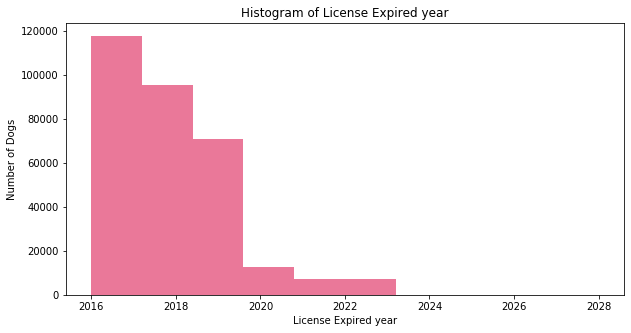

In [33]:
# Check out the distribution for "Dog_BirthYear" column
df_merged_clean1['LicenseExpiredyear'].plot(kind='hist', figsize=(10, 5), color='#ea7899')

plt.title('Histogram of License Expired year') # add a title
plt.ylabel('Number of Dogs') # add y-label
plt.xlabel('License Expired year') # add x-label

plt.show()

In [34]:
#Remove the rows where the license has expired.
df_merged_c = df_merged_clean1.drop(df_merged_clean1[df_merged_clean1['LicenseExpiredyear']<2020].index)  
df_merged_c.shape

(26994, 8)

In [35]:
# To see whether therea are any missing values
count = df_merged_c["LicenseExpiredDate"].isna().sum() 
print(count)

0


In [36]:
df_merged_c.head(5)

,Dog_Name,Dog_Gender,Dog_BirthYear,Breed_Name,LicenseExpiredDate,Borough,Neighborhood,LicenseExpiredyear
25,BEANS,M,2011,Boston Terrier,2020-03-17,Manhattan,East Harlem,2020
36,TALA,F,2009,Unknown,2020-03-22,Manhattan,East Harlem,2020
37,OLIVER,M,2005,Unknown,2020-03-22,Manhattan,East Harlem,2020
39,SHADOW,M,2013,American Pit Bull Mix / Pit Bull Mix,2020-03-22,Manhattan,East Harlem,2020
46,SPOTS,M,2010,Shih Tzu,2020-05-24,Manhattan,East Harlem,2020
